In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip install transformers requests beautifulsoup4 pandas numpy

In [1]:
!pip install -U selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 53.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.2/460.2 kB 17.0 MB/s eta 0:00:00


# Scraping the dataset using Selenium

In [ ]:
import os
import time
import random
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
import pandas as pd
import numpy as np

# Specify the path to your EdgeDriver executable
edge_path = os.path.join(os.getcwd(),'msedgedriver')

# Create a service object with the executable path
service = Service()

# Added options to make the webdriver appear less like a bot
options = webdriver.EdgeOptions()
options.add_argument("--disable-blink-features=AutomationControlled")

# Initialize the Edge WebDriver using the service and options
driver = webdriver.Edge(service=service, options=options)

# Navigate to the TripAdvisor restaurant page
url = 'https://www.tripadvisor.com/Restaurant_Review-g293936-d3195821-Reviews-Seasonal_Tastes-Dhaka_City_Dhaka_Division.html'
driver.get(url)
time.sleep(random.uniform(40.0, 50.0))  # Increased delay before clicking the "Reviews" button

# Scroll down a little
driver.execute_script("window.scrollTo(0, window.scrollY + 400)")

# Click on the "Reviews" button
reviews_button = driver.find_element(By.XPATH, "//a[@data-tab-name='Reviews']")
reviews_button.click()
time.sleep(random.uniform(5.0, 10.0))  # Increased delay after clicking the "Reviews" button

# Initialize lists to store review details
review_date = []
review_text = []
rating = []

while True:
    # Find review elements
    review_elements = driver.find_elements(By.XPATH, "//div[@class='review-container']")

    # Extract review details
    for review in review_elements:
        try:
            review_date.append(review.find_element(By.CLASS_NAME, "ratingDate").get_attribute("title"))
        except:
            review_date.append(None)
        try:
            review_text.append(review.find_element(By.CLASS_NAME, "partial_entry").text)
        except:
            review_text.append(None)
        try:
            rating.append(review.find_element(By.CLASS_NAME, "ui_bubble_rating").get_attribute("class").split("_")[-1])
        except:
            rating.append(None)

    # Check if there is a next page. If yes, navigate to the next page. If no, break the loop.
    try:
        next_button = driver.find_element(By.XPATH, "//a[contains(@class, 'nav next ui_button primary')]")
        time.sleep(random.uniform(30.0, 40.0))
        next_button.click()
        time.sleep(random.uniform(30.0, 40.0))
    except:
        break

# Create a DataFrame
reviews_df = pd.DataFrame({
    'Review Date': review_date,
    'Review Text': review_text,
    'Rating': rating
})

# Save the DataFrame to a CSV file
reviews_df.to_csv('tripadvisor_reviews.csv', index=False)

# Remember to close and quit the driver when done
driver.quit()


In [ ]:
import pandas as pd
df = pd.read_csv('tripadvisor_reviews.csv')
df["Rating"] = df["Rating"]/10
df.to_csv('tripadvisor_reviews_updated.csv', index=False)

# Sentiment Analysis

In [39]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np

In [40]:
df = pd.read_csv('/kaggle/input/restaurant-review-tripadvisor/tripadvisor_reviews_updated.csv')

In [42]:
df.head()

,Review Date,Review Text,Rating
0,"March 4, 2024",Had an amazing dinner with family. Today our s...,5.0
1,"March 4, 2024",Tonight dinner was wonderful dinner. I went my...,5.0
2,"March 4, 2024",Wide spread of buffet dinner. Really enjoyed i...,5.0
3,"February 27, 2024",Food at Seasonal taste was really delicious. P...,5.0
4,"February 26, 2024",It was a great experience considering both the...,5.0


In [43]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [44]:
tokens = tokenizer.encode('I did not like it at all.', return_tensors='pt')

In [45]:
tokens

tensor([[  101,   151, 12266, 10497, 11531, 10197, 10160, 10367,   119,   102]])

In [46]:
tokenizer.decode(tokens[0])

'[CLS] i did not like it at all. [SEP]'

In [47]:
result = model(tokens)

In [48]:
result

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.7665,  2.7285,  1.0436, -2.1548, -3.5632]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [49]:
torch.argmax(result.logits)

tensor(0)

In [50]:
# on sentiment score of 1-5, the sentence 'I did not like it at all.' gets score 1
int(torch.argmax(result.logits))+1

1

In [51]:
tokens2 = tokenizer.encode('I loved the movie very much.', return_tensors='pt')
tokens2

tensor([[  101,   151, 46747, 10103, 13113, 12495, 12977,   119,   102]])

In [52]:
result2 = model(tokens2)
result2

SequenceClassifierOutput(loss=None, logits=tensor([[-2.5397, -2.1097, -0.4202,  1.6735,  2.5546]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [53]:
torch.argmax(result2.logits)

tensor(4)

In [54]:
# on sentiment score of 1-5, the sentence 'I loved the movie very much.' gets score 5
int(torch.argmax(result2.logits))+1

5

In [64]:
df['Review Text'].iloc[0]

'Had an amazing dinner with family. Today our special day . It was great dayThe staff were amazingly friendly. Made our special night very special. Thank you.'

In [56]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [57]:
sentiment_score(df['Review Text'].iloc[1])

5

In [58]:
df['sentiment'] = df['Review Text'].apply(lambda x: sentiment_score(x[:512])) #takes first 512 tokens


In [60]:
df.head(10)

,Review Date,Review Text,Rating,sentiment
0,"March 4, 2024",Had an amazing dinner with family. Today our s...,5.0,5
1,"March 4, 2024",Tonight dinner was wonderful dinner. I went my...,5.0,5
2,"March 4, 2024",Wide spread of buffet dinner. Really enjoyed i...,5.0,5
3,"February 27, 2024",Food at Seasonal taste was really delicious. P...,5.0,4
4,"February 26, 2024",It was a great experience considering both the...,5.0,5
5,"February 26, 2024","Very good service, friendly & helpful staffs. ...",5.0,5
6,"February 26, 2024",The food is really fresh and good.....the ambi...,5.0,5
7,"February 25, 2024",Service has been top notch over the years. The...,5.0,5
8,"February 25, 2024","Very gentle environment, good food, relaxing I...",5.0,5
9,"February 25, 2024",The food was pretty Delightful. Loved the envi...,5.0,4


**We can see that the Ratings match the sentiment scores in most cases.**

# Visualization

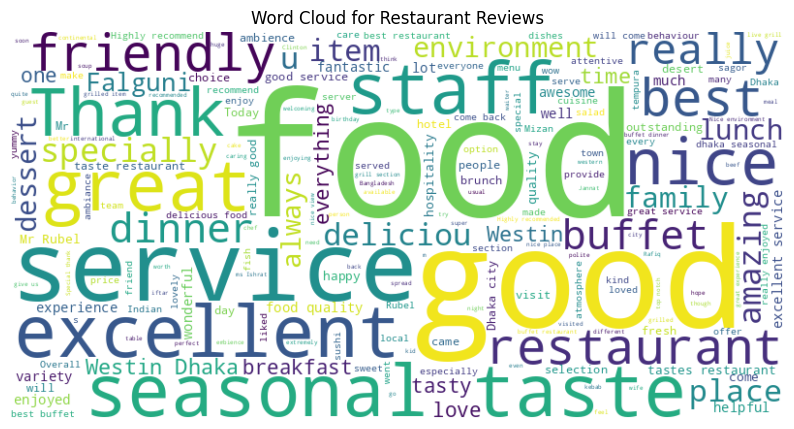

In [67]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming you have a DataFrame 'df' with a column 'Review Text'
# Extract the review text
reviews_text = ' '.join(df['Review Text'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud for Restaurant Reviews')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


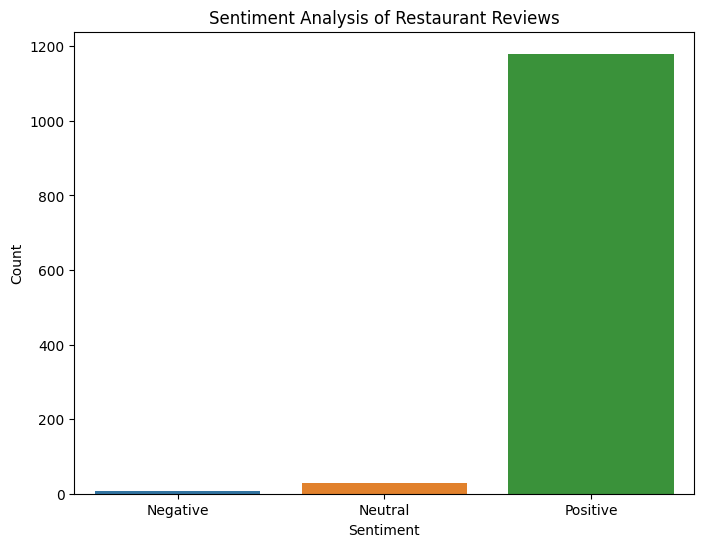

In [68]:
import seaborn as sns
from textblob import TextBlob  # For sentiment analysis

# Assuming you have a DataFrame 'df' with a column 'Review Text'
# Extract the review text
reviews_text = df['Review Text']

# Perform sentiment analysis on each review
sentiments = reviews_text.apply(lambda x: TextBlob(x).sentiment.polarity)

# Categorize sentiments
df['Sentiment'] = pd.cut(sentiments, bins=[-1, -0.1, 0.1, 1], labels=['Negative', 'Neutral', 'Positive'])

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Analysis of Restaurant Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


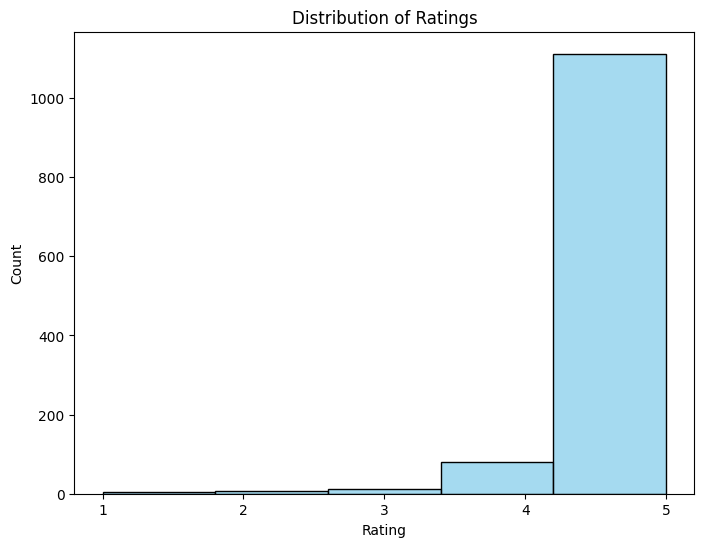

In [70]:
# Assuming you have a DataFrame 'df' with a column 'Rating'
plt.figure(figsize=(8, 6))
sns.histplot(df['Rating'], bins=5, kde=False, color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1, 6))
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


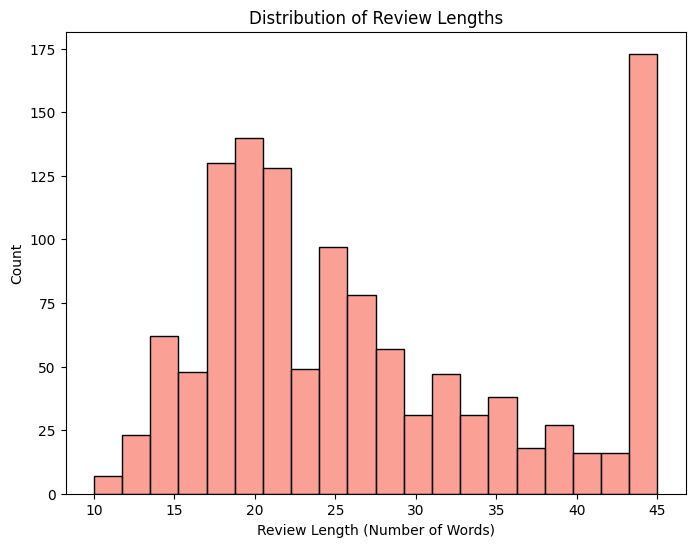

In [71]:
# Calculate review lengths
df['Review Length'] = df['Review Text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 6))
sns.histplot(df['Review Length'], bins=20, kde=False, color='salmon')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Count')
plt.show()
